<a href="https://colab.research.google.com/github/zeroxiga/ML-Predicting-Violent-Crime-in-a-Community/blob/main/Regression%20-%20Predicting%20Violent%20Crime%20in%20a%20Community.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression - Predicting Violent Crime in a Community
## Introduction
The dataset contains socio-economic data from the 1990 US census for various US communities, and the number of violent crimes per capita (in the column `ViolentCrimesPerPop`). 

According to the dataset information file `Communities_Info.txt`, the dataset consists a large number of variables, mainly group into two categories: socio-economic (race, age, employment, marital status, immigration and home ownership), and Law Enforcement Management and Administrative Statistics (LEMAS) data.  

Also, it is important to note that, as mentioned in the info file, all numeric data has been normalised into a range of 0.00-1.00 which preserves the ratios of values within an attribute. Outliers, defined as 3SD above or below are also allocated to the upper end and lower end of the scale, accordingly. However, because of this normalisation, comparing between values of different attributes values are no longer meaningul. Thus, it is fair to assume that there is no multicollinearity.

In [ ]:
# Import all the important packages
import pandas as pd
import numpy as np

# Visualisation
import seaborn as sns 
import matplotlib.pyplot as plt 

# Stats models is a package that is going to perform the regression analysis
from statsmodels import api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import cross_val_score

# os allows us to manipulate variables on out local machine, such as paths and environment variables
import os

# Self explainatory, dates and times
from datetime import datetime, date

# A helper package to help us iterate over objects
import itertools

## Load Data

In [ ]:
# Loading data, replace ? with NaN and remove spaces in columns names
filename = './Data/Q1/communities.csv'
data = pd.read_csv(filename,sep='\s*,\s*', engine='python', na_values=["?"])
data.head()

,state,county,community,communityname string,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03


In [ ]:
# Extract general information
num_rows = data.shape[0]
num_cols = data.shape[1]

print("The dataset has %d rows and %d columns" %(num_rows, num_cols))

The dataset has 1994 rows and 128 columns


In [ ]:
# General data information
print(data.info())
print(data.describe())

## Data Preparation and Cleansing
### Drop unused columns
Drop first 5 columns as there are non-predictive attributes for fitting linear regression model.

In [ ]:
# drop first 5 columns - not required
data.drop(['state', 'county', 'community', 'communityname string', 'fold'], inplace = True, axis = 1)
print("List all columns")
data.columns.tolist()

List all columns


['population',
 'householdsize',
 'racepctblack',
 'racePctWhite',
 'racePctAsian',
 'racePctHisp',
 'agePct12t21',
 'agePct12t29',
 'agePct16t24',
 'agePct65up',
 'numbUrban',
 'pctUrban',
 'medIncome',
 'pctWWage',
 'pctWFarmSelf',
 'pctWInvInc',
 'pctWSocSec',
 'pctWPubAsst',
 'pctWRetire',
 'medFamInc',
 'perCapInc',
 'whitePerCap',
 'blackPerCap',
 'indianPerCap',
 'AsianPerCap',
 'OtherPerCap',
 'HispPerCap',
 'NumUnderPov',
 'PctPopUnderPov',
 'PctLess9thGrade',
 'PctNotHSGrad',
 'PctBSorMore',
 'PctUnemployed',
 'PctEmploy',
 'PctEmplManu',
 'PctEmplProfServ',
 'PctOccupManu',
 'PctOccupMgmtProf',
 'MalePctDivorce',
 'MalePctNevMarr',
 'FemalePctDiv',
 'TotalPctDiv',
 'PersPerFam',
 'PctFam2Par',
 'PctKids2Par',
 'PctYoungKids2Par',
 'PctTeen2Par',
 'PctWorkMomYoungKids',
 'PctWorkMom',
 'NumIlleg',
 'PctIlleg',
 'NumImmig',
 'PctImmigRecent',
 'PctImmigRec5',
 'PctImmigRec8',
 'PctImmigRec10',
 'PctRecentImmig',
 'PctRecImmig5',
 'PctRecImmig8',
 'PctRecImmig10',
 'PctSpeakEng

### Null Values
Analysing percentage of Null values per column

In [ ]:
# List columns that contain null values
df = pd.DataFrame({'Null-Value Percentage': data.isna().mean().round(4) * 100})
df[df['Null-Value Percentage'] > 0]

,Null-Value Percentage
OtherPerCap,0.05
LemasSwornFT,84.00
LemasSwFTPerPop,84.00
LemasSwFTFieldOps,84.00
LemasSwFTFieldPerPop,84.00
LemasTotalReq,84.00
LemasTotReqPerPop,84.00
PolicReqPerOffic,84.00
PolicPerPop,84.00
RacialMatchCommPol,84.00


The following columns are removed due to high percentage of null values.

In [ ]:
data.drop(df[df['Null-Value Percentage'] > 80].index.tolist(), inplace = True, axis = 1)

For column [OtherPerCap], we shall fill missing values with median value of the column.

In [ ]:
data['OtherPerCap'].fillna(data['OtherPerCap'].median(), inplace=True)

### Non-Socio-Economic Data
In addition, because the question is to explore the link between the various socio-economic factors and crime, the rest of the  non-socioeconomic attributes (namely `LandArea`,`PctUsePubTrans` and `LemasPctOfficDrugUn`) are removed.

With this, we shall have 97 variable and 1 response variable

In [ ]:
data.drop(['LandArea', 'PctUsePubTrans', 'LemasPctOfficDrugUn'], inplace = True, axis = 1)
print("List all columns")
data.columns.tolist()
data.shape

List all columns


(1994, 98)

### Split data
Split data into trainig (60%), validation (20%) and testing sets. (20%)

In [ ]:
# split into train/test split
train, validate, test = np.split(data.sample(frac=1), [int(.6*len(data)), int(.8*len(data))])
print(train.shape)
print(validate.shape)
print(test.shape)

(1196, 98)
(399, 98)
(399, 98)


,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,PopDens,ViolentCrimesPerPop
1140,0.00,0.38,0.08,0.92,0.02,0.04,0.36,0.48,0.30,0.56,...,0.47,0.05,0.00,0.01,0.98,0.61,0.88,0.91,0.37,0.21
1021,0.00,0.40,0.01,0.81,0.24,0.28,0.51,0.71,0.53,0.34,...,0.37,0.00,0.01,0.23,0.69,0.36,0.67,0.62,0.29,0.20
71,0.05,0.46,0.02,0.88,0.20,0.17,0.35,0.40,0.24,0.36,...,0.22,0.04,0.06,0.26,0.61,0.46,0.53,0.79,0.29,0.21
1897,0.04,0.53,0.01,0.95,0.19,0.02,0.38,0.45,0.29,0.29,...,0.37,0.00,0.00,0.17,0.75,0.78,0.83,0.75,0.12,0.15
973,0.06,0.66,1.00,0.00,0.06,0.28,0.42,0.55,0.36,0.29,...,0.71,0.00,0.04,0.45,0.48,0.62,0.67,0.66,0.64,0.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1069,0.24,0.31,0.03,0.81,0.29,0.18,0.40,0.56,0.38,0.46,...,0.36,0.32,0.37,0.24,0.57,0.44,0.63,0.52,0.12,0.33
428,0.03,0.48,0.02,0.78,0.02,0.65,0.42,0.43,0.28,0.58,...,0.35,0.01,0.03,0.14,0.79,0.59,0.60,0.86,0.09,0.71
138,0.00,0.33,0.41,0.67,0.01,0.01,0.47,0.47,0.33,0.56,...,0.44,0.00,0.00,0.00,0.72,0.63,0.74,0.76,0.10,0.38
835,0.02,0.67,0.18,0.59,0.42,0.34,0.44,0.57,0.32,0.19,...,0.28,0.01,0.00,0.32,0.40,0.24,0.37,0.28,0.36,0.29


## Linear Regression Model

Linear Regression is fitted first as it is a simple model that can serve as a baseline for other models built. Let’s construct a full model including all the variables.

Model 1 RMSE = 0.1419270541675252
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.861
Model:                            OLS   Adj. R-squared (uncentered):              0.848
Method:                 Least Squares   F-statistic:                              69.99
Date:                Sat, 11 Apr 2020   Prob (F-statistic):                        0.00
Time:                        14:35:15   Log-Likelihood:                          802.86
No. Observations:                1196   AIC:                                     -1412.
Df Residuals:                    1099   BIC:                                     -918.3
Df Model:                          97                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-------

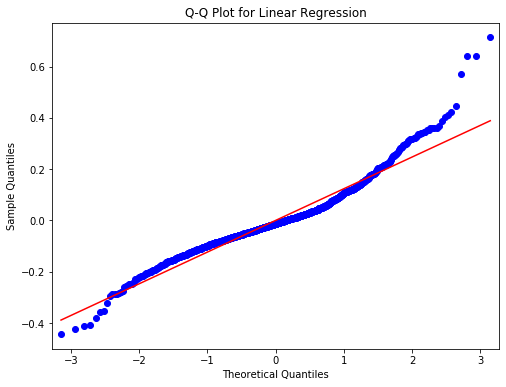

Text(0.5, 1.0, 'Coefficients')

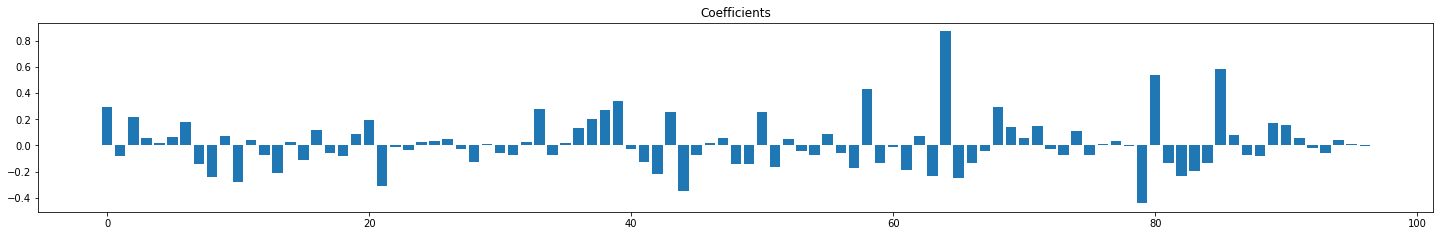

In [ ]:
# Train Data
X_train = train.drop('ViolentCrimesPerPop', axis=1)
Y_train = train['ViolentCrimesPerPop']

# Test Data
X_test = test.drop('ViolentCrimesPerPop', axis=1)
Y_test = test['ViolentCrimesPerPop']

# Validation Data
X_val = validate.drop('ViolentCrimesPerPop', axis=1)
Y_val = validate['ViolentCrimesPerPop']

# create the linear model
linear_model = sm.OLS(Y_train.to_numpy(), X_train.to_numpy()).fit()
linear = LinearRegression(fit_intercept = False).fit(X = X_train.to_numpy(), y = Y_train.to_numpy())
# fit the model without any regularisation
pred = linear_model.predict(X_val)
print('Model 1 RMSE = {}'.format(
  np.sqrt(mean_squared_error(Y_val, linear_model.predict(X_val)))))
print(linear_model.summary())
fig, ax = plt.subplots(figsize=(8,6))
sm.qqplot(linear_model.resid, ax=ax, line='s')
plt.title('Q-Q Plot for Linear Regression')
plt.show()
fig = plt.figure(figsize=[25, 16])
ax = fig.add_subplot(4, 1, 1)
ax.bar(range(len(linear_model.params)), linear_model.params)
ax.set_title('Coefficients')

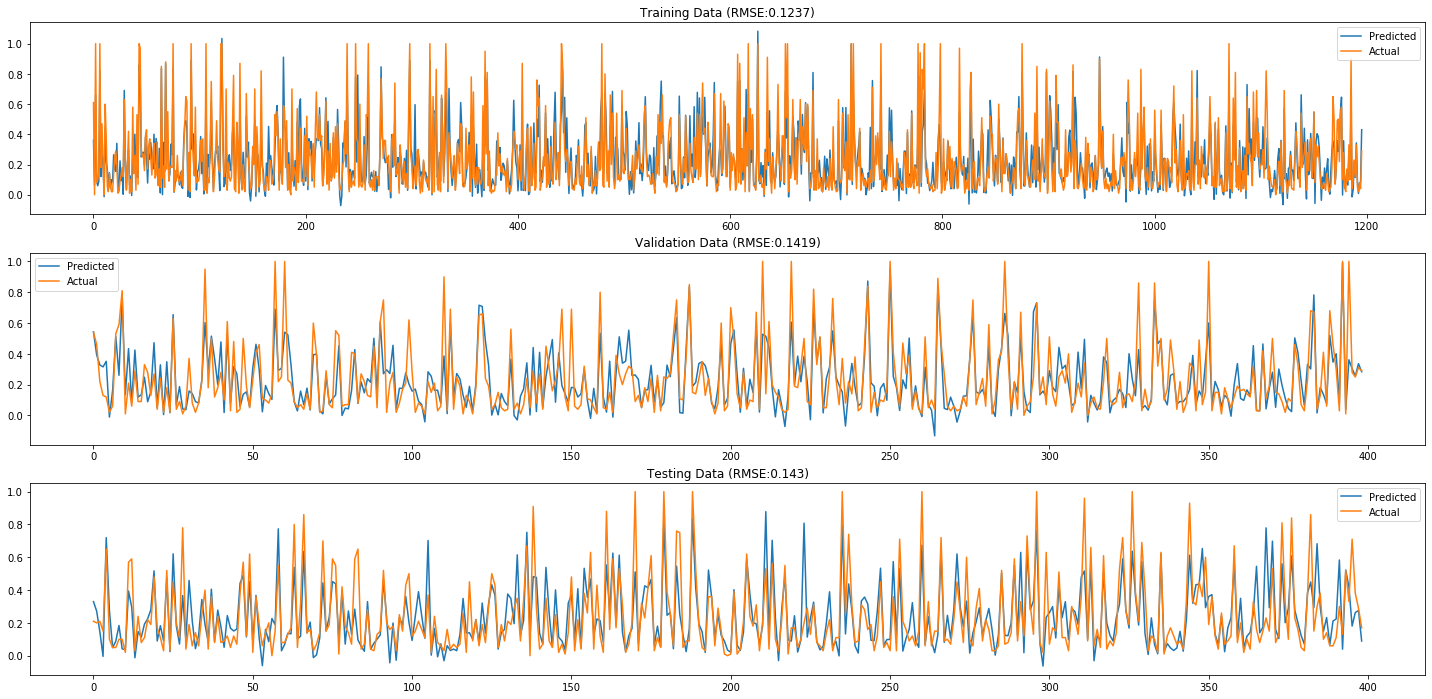

In [ ]:
# RMSE for each set
linear_rmse_train = np.sqrt(mean_squared_error(Y_train, linear_model.predict(X_train)))
linear_rmse_val = np.sqrt(mean_squared_error(Y_val, linear_model.predict(X_val)))
linear_rmse_test = np.sqrt(mean_squared_error(Y_test, linear_model.predict(X_test)))

# Plot for prediction performance
fig = plt.figure(figsize=[25, 12])
ax = fig.add_subplot(3, 1, 1)
ax.plot(linear_model.predict(X_train.to_numpy()), label='Predicted')
ax.plot(Y_train.to_numpy(), label='Actual')
ax.set_title('Training Data (RMSE:{})'.format(round(linear_rmse_train,4)))
ax.legend()
ax = fig.add_subplot(3, 1, 2)
ax.plot(linear_model.predict(X_val.to_numpy()), label='Predicted')
ax.plot(Y_val.to_numpy(), label='Actual')
ax.set_title('Validation Data (RMSE:{})'.format(round(linear_rmse_val,4)))
ax.legend()
ax = fig.add_subplot(3, 1, 3)
ax.plot(linear_model.predict(X_test.to_numpy()), label='Predicted')
ax.plot(Y_test.to_numpy(), label='Actual')
ax.set_title('Testing Data (RMSE:{})'.format(round(linear_rmse_test,4)))
ax.legend();


## Lasso

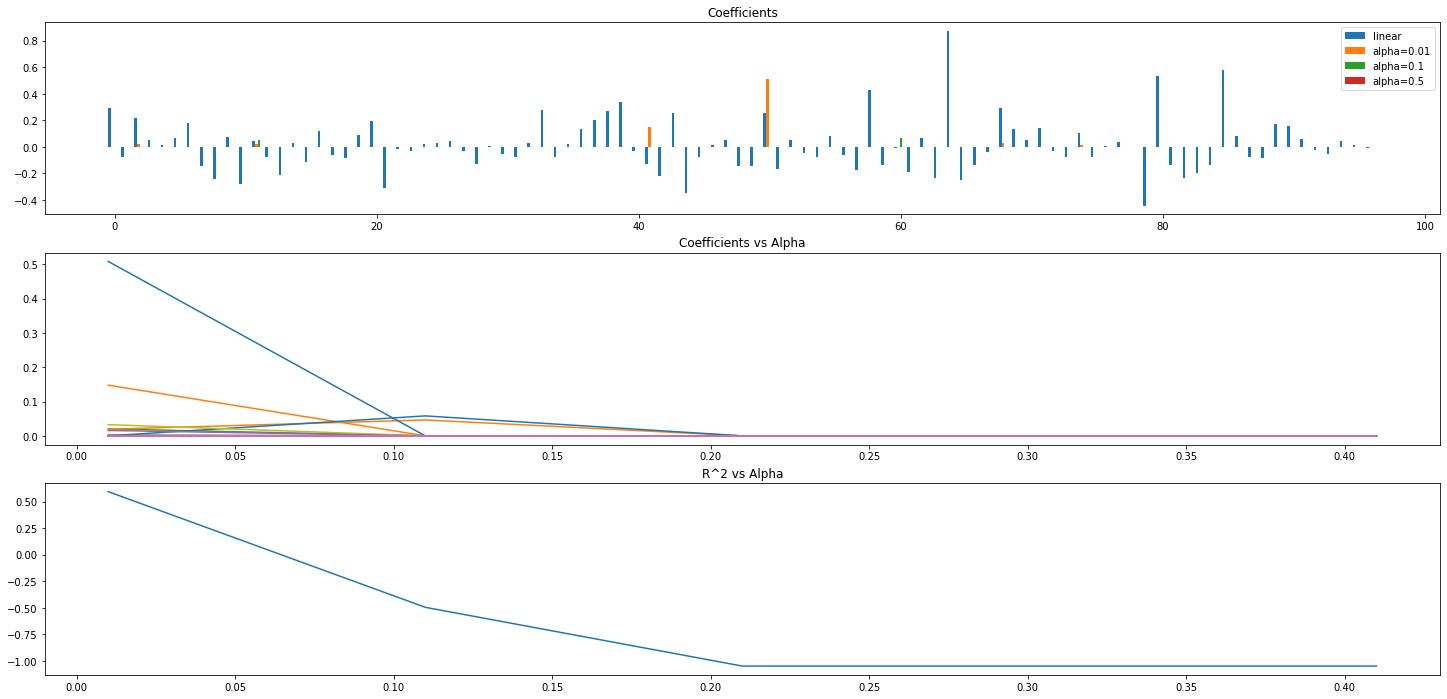

In [ ]:
lasso_alphas = np.arange(0.01, 0.5, 0.1)
lasso_train_r_2 = []
lasso_val_r_2 = []
lasso_test_r_2 = []
lasso_coeff = []
lasso_train_acc = []
lasso_val_acc = []
lasso_test_acc = []

lasso_model_1 = Lasso(fit_intercept=False, alpha=0.01).fit(X = X_train.to_numpy(), y = Y_train.to_numpy())
lasso_model_2 = Lasso(fit_intercept=False, alpha=0.1).fit(X = X_train.to_numpy(), y = Y_train.to_numpy())
lasso_model_3 = Lasso(fit_intercept=False, alpha=0.5).fit(X = X_train.to_numpy(), y = Y_train.to_numpy())

for a in lasso_alphas:
    lasso_model = Lasso(fit_intercept=False, alpha=a).fit(X = X_train.to_numpy(), y = Y_train.to_numpy())
    lasso_coeff.append(lasso_model.coef_)
    lasso_train_r_2.append(lasso_model.score(X = X_train.to_numpy(), y = Y_train.to_numpy()))
    lasso_val_r_2.append(lasso_model.score(X = X_val.to_numpy(), y = Y_val.to_numpy()))
    lasso_test_r_2.append(lasso_model.score(X = X_test.to_numpy(), y = Y_test.to_numpy()))
    lasso_train_acc.append(np.sqrt(np.mean((lasso_model.predict(X_train.to_numpy()) - Y_train.to_numpy())**2)))
    lasso_val_acc.append(np.sqrt(np.mean((lasso_model.predict(X_val.to_numpy()) - Y_val.to_numpy())**2)))
    lasso_test_acc.append(np.sqrt(np.mean((lasso_model.predict(X_test.to_numpy()) - Y_test.to_numpy())**2)))

fig = plt.figure(figsize=[25, 12])
ax = fig.add_subplot(3, 1, 1)
w = 0.2
pos = np.arange(0, len(linear.coef_), 1)
ax.bar(pos - w*2, linear.coef_, width=w, label='linear')
ax.bar(pos - w, lasso_model_1.coef_, width=w, label='alpha=0.01')
ax.bar(pos, lasso_model_2.coef_, width=w, label='alpha=0.1')
ax.bar(pos + w, lasso_model_3.coef_, width=w, label='alpha=0.5')
ax.legend()
ax.set_title('Coefficients')
ax = fig.add_subplot(3, 1, 2)
ax.plot(lasso_alphas, lasso_coeff)
ax.set_title('Coefficients vs Alpha')
ax = fig.add_subplot(3, 1, 3)
ax.plot(lasso_alphas, lasso_train_r_2)
ax.set_title('R^2 vs Alpha')
plt.show()

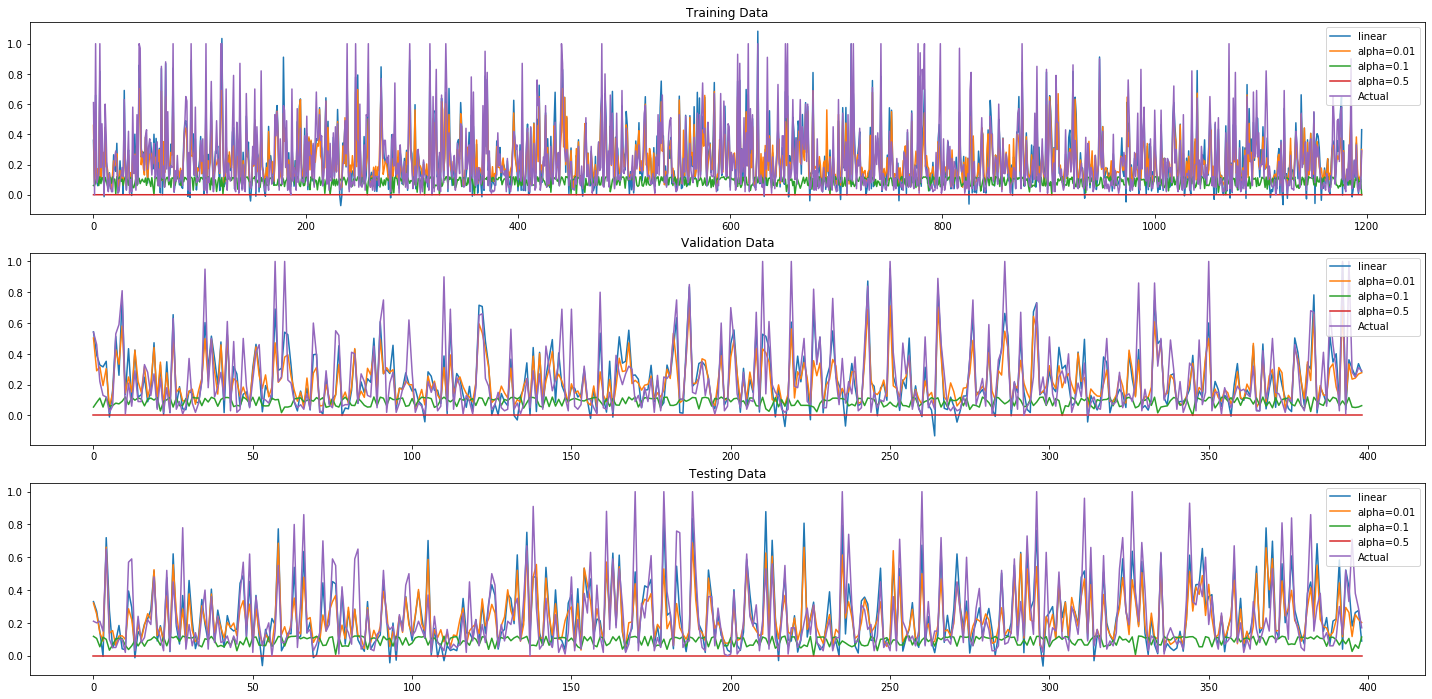

In [ ]:
# Lasso Prediction performance
fig = plt.figure(figsize=[25, 12])
ax = fig.add_subplot(3, 1, 1)
ax.plot(linear.predict(X_train), label='linear')
ax.plot(lasso_model_1.predict(X_train), label='alpha=0.01')
ax.plot(lasso_model_2.predict(X_train), label='alpha=0.1')
ax.plot(lasso_model_3.predict(X_train), label='alpha=0.5')
ax.plot(Y_train.to_numpy(), label='Actual')
ax.set_title('Training Data')
ax.legend()
ax = fig.add_subplot(3, 1, 2)
ax.plot(linear.predict(X_val), label='linear')
ax.plot(lasso_model_1.predict(X_val), label='alpha=0.01')
ax.plot(lasso_model_2.predict(X_val), label='alpha=0.1')
ax.plot(lasso_model_3.predict(X_val), label='alpha=0.5')
ax.plot(Y_val.to_numpy(), label='Actual')
ax.set_title('Validation Data')
ax.legend()
ax = fig.add_subplot(3, 1, 3)
ax.plot(linear.predict(X_test), label='linear')
ax.plot(lasso_model_1.predict(X_test), label='alpha=0.01')
ax.plot(lasso_model_2.predict(X_test), label='alpha=0.1')
ax.plot(lasso_model_3.predict(X_test), label='alpha=0.5')
ax.plot(Y_test.to_numpy(), label='Actual')
ax.set_title('Testing Data')
ax.legend();  

0.01


Text(0.5, 1.0, 'Testing Data (alpha:0.01)')

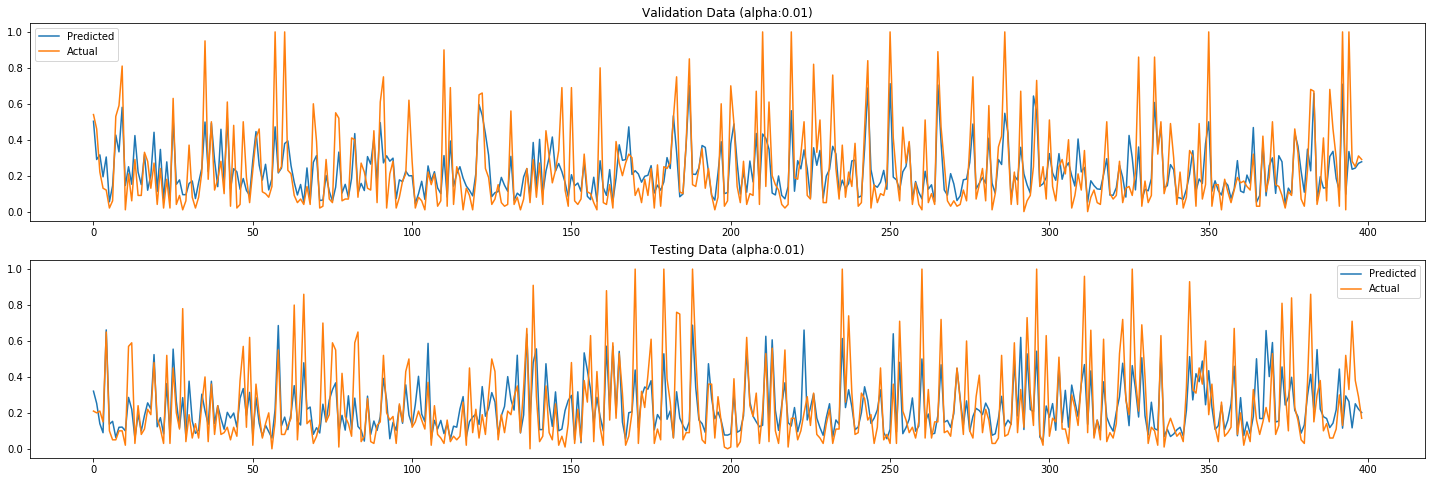

In [ ]:
# Fit Lasso using best Alpha
best_lasso_alpha = lasso_alphas[lasso_val_acc.index(min(lasso_val_acc))]
print(best_lasso_alpha)
lasso_model = Lasso(fit_intercept=False, alpha=best_lasso_alpha).fit(X = X_train.to_numpy(), y = Y_train.to_numpy())

fig = plt.figure(figsize=[25, 8])
ax = fig.add_subplot(2, 1, 1)
ax.plot(lasso_model.predict(X_val), label='Predicted')
ax.plot(Y_val.to_numpy(), label='Actual')
ax.legend()
ax.set_title('Validation Data (alpha:{})'.format(best_lasso_alpha))
ax = fig.add_subplot(2, 1, 2)
ax.plot(lasso_model.predict(X_test), label='Predicted')
ax.plot(Y_test.to_numpy(), label='Actual')
ax.legend()
ax.set_title('Testing Data (alpha:{})'.format(best_lasso_alpha))

### Ridge regression

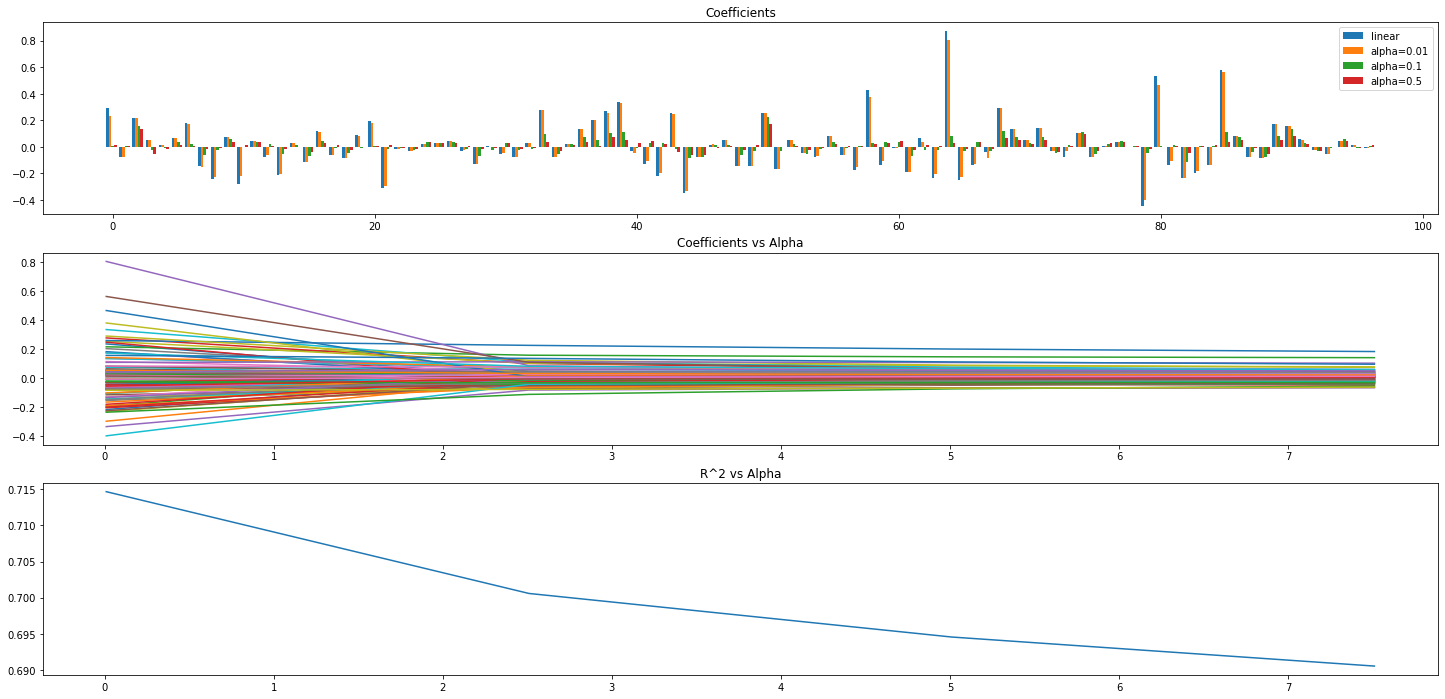

In [ ]:
ridge_alphas = np.arange(0.01, 10, 2.5)
ridge_train_r_2 = []
ridge_val_r_2 = []
ridge_test_r_2 = []
ridge_coeff = []
ridge_train_acc = []
ridge_val_acc = []
ridge_test_acc = []

ridge_model_1 = Ridge(fit_intercept=False, alpha=0.01).fit(X = X_train.to_numpy(), y = Y_train.to_numpy())
ridge_model_2 = Ridge(fit_intercept=False, alpha=2.5).fit(X = X_train.to_numpy(), y = Y_train.to_numpy())
ridge_model_3 = Ridge(fit_intercept=False, alpha=10).fit(X = X_train.to_numpy(), y = Y_train.to_numpy())

# compute ridge models, storing data as we did for Lasso
for a in ridge_alphas:
    ridge = Ridge(fit_intercept=False, alpha=a).fit(X = X_train.to_numpy(), y = Y_train.to_numpy())
    ridge_coeff.append(ridge.coef_)
    ridge_train_r_2.append(ridge.score(X = X_train.to_numpy(), y = Y_train.to_numpy()))
    ridge_val_r_2.append(ridge.score(X = X_val.to_numpy(), y = Y_val.to_numpy()))
    ridge_test_r_2.append(ridge.score(X = X_test.to_numpy(), y = Y_test.to_numpy()))
    ridge_train_acc.append(np.sqrt(np.mean((ridge.predict(X_train.to_numpy()) - Y_train.to_numpy())**2)))
    ridge_val_acc.append(np.sqrt(np.mean((ridge.predict(X_val.to_numpy()) - Y_val.to_numpy())**2)))
    ridge_test_acc.append(np.sqrt(np.mean((ridge.predict(X_test.to_numpy()) - Y_test.to_numpy())**2)))
    
fig = plt.figure(figsize=[25, 12])
ax = fig.add_subplot(3, 1, 1)
w = 0.2
pos = np.arange(0, len(linear.coef_), 1)
ax.bar(pos - w*2, linear.coef_, width=w, label='linear')
ax.bar(pos - w, ridge_model_1.coef_, width=w, label='alpha=0.01')
ax.bar(pos, ridge_model_2.coef_, width=w, label='alpha=0.1')
ax.bar(pos + w, ridge_model_3.coef_, width=w, label='alpha=0.5')
ax.legend()
ax.set_title('Coefficients')
ax = fig.add_subplot(3, 1, 2)
ax.plot(ridge_alphas, ridge_coeff)
ax.set_title('Coefficients vs Alpha')
ax = fig.add_subplot(3, 1, 3)
ax.plot(ridge_alphas, ridge_train_r_2)
ax.set_title('R^2 vs Alpha')
plt.show()

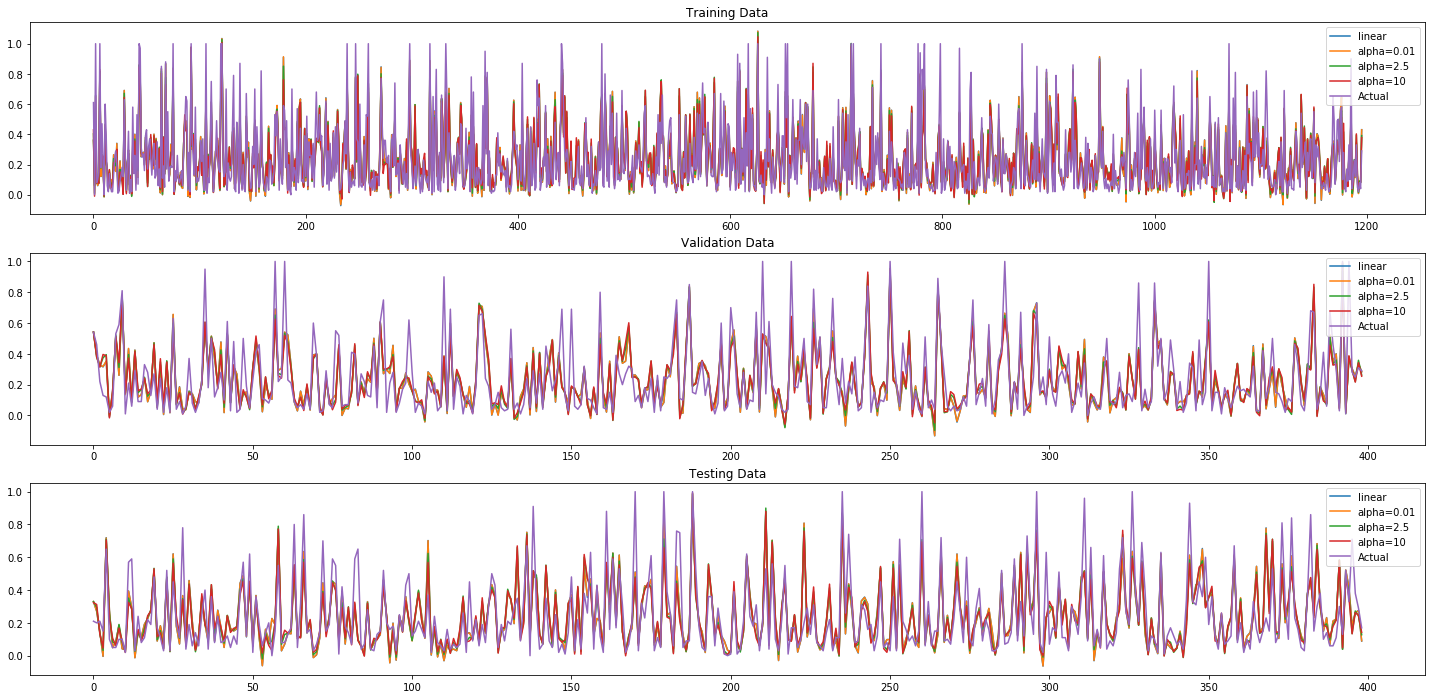

In [ ]:
# Ridge Model Prediction performance
fig = plt.figure(figsize=[25, 12])
ax = fig.add_subplot(3, 1, 1)
ax.plot(linear.predict(X_train), label='linear')
ax.plot(ridge_model_1.predict(X_train), label='alpha=0.01')
ax.plot(ridge_model_2.predict(X_train), label='alpha=2.5')
ax.plot(ridge_model_3.predict(X_train), label='alpha=10')
ax.plot(Y_train.to_numpy(), label='Actual')
ax.set_title('Training Data')
ax.legend()
ax = fig.add_subplot(3, 1, 2)
ax.plot(linear.predict(X_val), label='linear')
ax.plot(ridge_model_1.predict(X_val), label='alpha=0.01')
ax.plot(ridge_model_2.predict(X_val), label='alpha=2.5')
ax.plot(ridge_model_3.predict(X_val), label='alpha=10')
ax.plot(Y_val.to_numpy(), label='Actual')
ax.set_title('Validation Data')
ax.legend()
ax = fig.add_subplot(3, 1, 3)
ax.plot(linear.predict(X_test), label='linear')
ax.plot(ridge_model_1.predict(X_test), label='alpha=0.01')
ax.plot(ridge_model_2.predict(X_test), label='alpha=2.5')
ax.plot(ridge_model_3.predict(X_test), label='alpha=10')
ax.plot(Y_test.to_numpy(), label='Actual')
ax.set_title('Testing Data')
ax.legend();

2.51


Text(0.5, 1.0, 'Testing Data (alpha:2.51)')

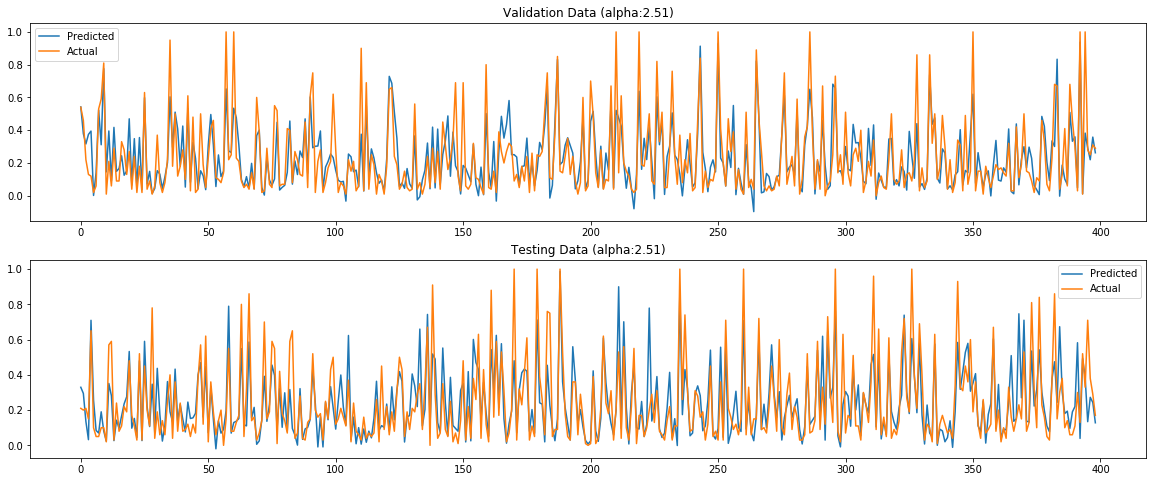

In [ ]:
# Fit Lasso using best Alpha
best_ridge_alpha = ridge_alphas[ridge_val_acc.index(min(ridge_val_acc))]
print(best_ridge_alpha)
ridge_model = Ridge(fit_intercept=False, alpha=best_ridge_alpha).fit(X = X_train.to_numpy(), y = Y_train.to_numpy())

fig = plt.figure(figsize=[20, 8])
ax = fig.add_subplot(2, 1, 1)
ax.plot(ridge_model.predict(X_val), label='Predicted')
ax.plot(Y_val.to_numpy(), label='Actual')
ax.legend()
ax.set_title('Validation Data (alpha:{})'.format(best_ridge_alpha))
ax = fig.add_subplot(2, 1, 2)
ax.plot(ridge_model.predict(X_test), label='Predicted')
ax.plot(Y_test.to_numpy(), label='Actual')
ax.legend()
ax.set_title('Testing Data (alpha:{})'.format(best_ridge_alpha))

## Final Evaluation
Because, we can, let's have a look at the three models (linear, lasso and ridge) side by side.

Text(0.5, 1.0, 'Testing Data')

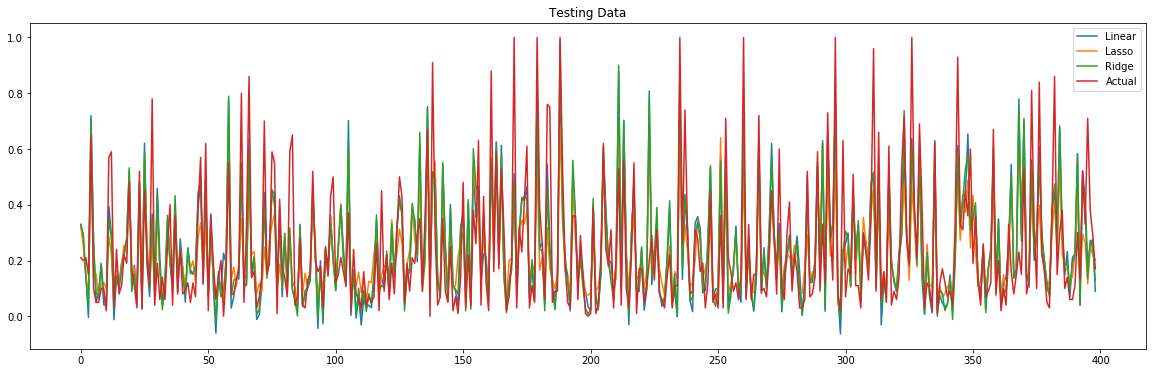

In [ ]:
fig = plt.figure(figsize=[20, 6])
ax = fig.add_subplot(1, 1, 1)
ax.plot(linear_model.predict(X_test.to_numpy()), label='Linear')
ax.plot(lasso_model.predict(X_test.to_numpy()), label='Lasso')
ax.plot(ridge_model.predict(X_test.to_numpy()), label='Ridge')
ax.plot(Y_test.to_numpy(), label='Actual')
ax.legend()
ax.set_title('Testing Data')

Let's see RMSE

In [ ]:
# RMSE & R-Squared
print('Linear Model, Test RMSE: ' + str(round(np.sqrt(np.mean((linear_model.predict(X_test.to_numpy()) - Y_test.to_numpy())**2)),4)) + ', R-Squared: ' + str(round(r2_score(Y_test, linear_model.predict(X_test.to_numpy())),4)))
print('Lasso Model, Test RMSE:  ' + str(round(np.sqrt(np.mean((lasso_model.predict(X_test.to_numpy()) - Y_test.to_numpy())**2)),4)) + ', R-Squared: ' + str(round(lasso_model.score(X = X_test.to_numpy(), y = Y_test.to_numpy()),4)))
print('Ridge Model, Test RMSE:  ' + str(round(np.sqrt(np.mean((ridge_model.predict(X_test.to_numpy()) - Y_test.to_numpy())**2)),4)) + ', R-Squared: ' + str(round(ridge_model.score(X = X_test.to_numpy(), y = Y_test.to_numpy()),4)))

Linear Model, Test RMSE: 0.143, R-Squared: 0.6213
Lasso Model, Test RMSE:  0.1602, R-Squared: 0.5248
Ridge Model, Test RMSE:  0.1432, R-Squared: 0.6203


QQ-Plot

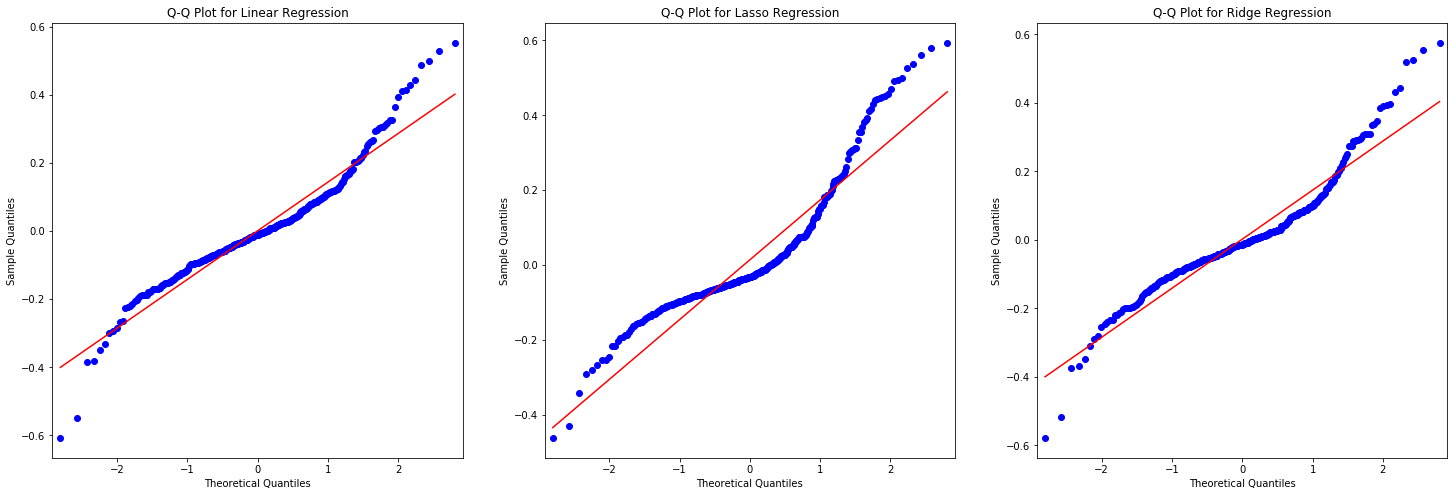

In [ ]:
fig = plt.figure(figsize=[25, 8])
ax = fig.add_subplot(1, 3, 1)
sm.qqplot(Y_test-linear_model.predict(X_test.to_numpy()), ax=ax, line='s')
plt.title('Q-Q Plot for Linear Regression')
ax = fig.add_subplot(1, 3, 2)
sm.qqplot(Y_test-lasso_model.predict(X_test.to_numpy()), ax=ax, line='s')
plt.title('Q-Q Plot for Lasso Regression')
ax = fig.add_subplot(1, 3, 3)
sm.qqplot(Y_test-ridge_model.predict(X_test.to_numpy()), ax=ax, line='s')
plt.title('Q-Q Plot for Ridge Regression')
plt.show()